<a href="https://colab.research.google.com/github/susandong/w266_final_project_game_sentiment/blob/master/w266_Final_Project_Game_Review_Sentiment_Analysis_1031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Game Review Sentiment Analysis Over Time
## Research Question: 
* Can we use sentiment analysis score to predict the active user base for video games over time

## Dataset: 
* Game Review: twitter/reddit/discord/steam reviews
* active user base: steam

## Algorithm: 
* Baseline(logistic Regression); 
* Transformer(Elmo/Bert)


In [2]:
#Load libraries
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
""" Download Data: There are 4 games with review data
Fall Guys (fg)
PlayerUnknown Battlegrounds (pubg)
Dota 2 (dota2)
Counterstrike Source: Go (csgo)

Review data has the following columns:
app: ID for the game
useful: how many users voted the review as useful
funny: how many users voted the review as funny
username: username of the person who wrote the review
games_owned: how many games the reviewer owns on Steam
num_reviews: how many reviews the reviewer has written on Steam
recommend: 1 for recommend (thumbs up), -1 for do not recommend (thumbs down)
hours_played: number of hours the reviewer played before writing the review
date: date review was written
text: text of the review
"""
#Fall Guys
fg_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/fallguys_reviews.csv'
fg_df = pd.read_csv(fg_url, error_bad_lines=False)
fg_df = fg_df.dropna()

#CS: Go
csgo_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/csgo_reviews.csv'
csgo_df = pd.read_csv(csgo_url, error_bad_lines=False)
csgo_df = csgo_df.dropna()

#PUBG
pubg_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/pubg_reviews.csv'
pubg_df = pd.read_csv(pubg_url, error_bad_lines=False)
pubg_df = pubg_df.dropna()

#Communication games
comm_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/comm_reviews.csv'
comm_df = pd.read_csv(comm_url, error_bad_lines=False)
comm_df = comm_df.dropna()

#Sports games
sports_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/sports_reviews.csv'
sports_df = pd.read_csv(sports_url, error_bad_lines=False)
sports_df = sports_df.dropna()

#FPS games
fps_url = 'https://raw.githubusercontent.com/susandong/w266_final_project_game_sentiment/master/data/fps_reviews.csv'
fps_df = pd.read_csv(fps_url, error_bad_lines=False)
fps_df = fps_df.dropna()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
from nltk.tokenize import RegexpTokenizer
def remove_blankrow(df,column):
  tokenizer = RegexpTokenizer(r'\w+')
  df['lens'] =[len(tokenizer.tokenize(utterance)) for utterance in df[column]]
  df_clean=df[df['lens'] !=0]
  return df_clean

In [18]:
# Data Preprocessing
!pip install unidecode
import unidecode
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

tknzr = TweetTokenizer()
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
#lemma = WordNetLemmatizer()

#Convert accented characters
def remove_accents(text):
  try:
    text = unidecode.unidecode(text)
  except:
    pass
  return text

#Remove digits and punctuation
def remove_nonletters(text):
  try:
    #Remove digits AND punctuation
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    #Remove just digits that are by themselves
    #text = re.sub('^\d+\s|\s\d+\s|\s\d+$', ' ', text)
  except:
    pass
  return text


#Use Tweet Tokenizer for some built-in emoji support
def tweet_tokenization(text):
  try:
    return tknzr.tokenize(text)
  except:
    pass

def remove_stopwords(token):
  try:
    return [item for item in token if item not in stop_words]
  except:
    pass

def remove_stemmer(token):
  try:
    return [stemmer.stem(i) for i in token]
  except:
    pass

def remove_lemmatizer(token):
  try:
    return [lemma.lemmatize(word=w, pow='v') for w in token]
  except:
    pass
  
def remove_shortwords(token):
  try:
    return [i for i in token if len(i) > 1]
  except:
    pass

def token_to_string(listTokens):
  return ' '.join(listTokens)

#Process text from dataframe. df = dataframe to clean, text = name of column with text
def process_text(df, text):  
  #Create new column for cleaned text
  df['cleaned'] = df[text]

  #Lower case all text
  df['cleaned'] = df['cleaned'].str.lower()

  #Clean URLs
  df['cleaned'] = df['cleaned'].str.replace('http\S+|www.\S+', '', case=False)

  #Remove accents from text
  #df['cleaned'] = df['cleaned'].apply(remove_accents)

  #Remove numbers and punctuation from text
  df['cleaned'] = df['cleaned'].apply(remove_nonletters)
  
  #Tokenize
  df['cleaned'] = df['cleaned'].apply(tweet_tokenization)

  #Remove stopwords
  #df['cleaned'] = df['cleaned'].apply(remove_stopwords)
  
  #Remove short words
  df['cleaned'] = df['cleaned'].apply(remove_shortwords)

  #Stemming - can decide to use or not
  #df['cleaned'] = df['cleaned'].apply(remove_stemmer)

  #Convert tokens back to string
  df['cleaned'] = df['cleaned'].apply(token_to_string)

  #Remove blankrows
  df = remove_blankrow(df, 'cleaned')

  #Remove overly long reviews
  df =df[df.lens<(df['lens'].quantile(0.90))]

  #Change negative review from -1 to 0
  df['recommend'] = df['recommend'].replace([-1],0)

  #Use only recommend and cleaned columns
  df = df[["recommend","cleaned"]]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
#preprocess all the datasets for all 3 games
process_text(fg_df, 'text')
process_text(csgo_df, 'text')
process_text(pubg_df, 'text')
process_text(comm_df, 'text')
process_text(sports_df, 'text')
process_text(fps_df, 'text')

In [20]:
comm_df

,app,useful,funny,username,games_owned,num_reviews,recommend,hours_played,date,text,cleaned,lens
0,1211630,0,0,7.65612E+16,48,4,1,10.1,"5 November, 2020",Pog,pog,1
1,1211630,0,0,vukand12,50,5,1,4.5,"5 November, 2020",play at school if you can for amazing results,play at school if you can for amazing results,9
2,1211630,0,0,Miffelmesh,24,3,1,3.8,"5 November, 2020",This is the first Jackbox Party Pack that I've...,this is the first jackbox party pack that ve p...,52
3,1211630,0,0,7.65612E+16,50,1,1,3.4,"5 November, 2020",stan Talking Points,stan talking points,3
4,1211630,0,0,7.65612E+16,8,1,1,9.5,"4 November, 2020",We play Champed Up a lot! Good fun and the dr...,we play champed up lot good fun and the drawin...,43
...,...,...,...,...,...,...,...,...,...,...,...,...
93749,945360,0,0,7.65612E+16,3,1,1,38.5,"29 October, 2020",great game for big brain people,great game for big brain people,6
93750,945360,0,0,1.23457E+28,204,3,1,61.0,"29 October, 2020","Despite everything that is happening, this gam...",despite everything that is happening this game...,20
93751,945360,0,0,7.65612E+16,6,1,1,12.7,"29 October, 2020",v good,good,1
93752,945360,0,0,7.65612E+16,3,1,1,69.6,"29 October, 2020",Its really fun and can have great times with F...,its really fun and can have great times with f...,10


In [10]:
#concatenate all 3 games data to one large dataset
all_df=pd.concat([fg_df,csgo_df,pubg_df])
all_clean_df = all_df[["recommend","cleaned"]]
comm_clean_df = comm_df[["recommend","cleaned"]]
sports_clean_df = sports_df[["recommend","cleaned"]]
fps_clean_df = fps_df[["recommend","cleaned"]]
sports_clean_df

,recommend,cleaned
0,-1,what different vs the previous one more sweat
1,1,its on sale so dont mind it but if pay full pr...
2,1,sometimes question my life choices don buy thi...
3,-1,
4,-1,in the trash
...,...,...
16835,-1,lots of improvement needed some third kits are...
16836,-1,game ever
16837,1,mean its pure cancer but good game
16838,-1,no


In [12]:
#df_final=remove_blankrow(all_clean_df,'cleaned')
#comm_clean_df = remove_blankrow(comm_clean_df, 'cleaned')
#sports_clean_df = remove_blankrow(comm_clean_df, 'cleaned')
#fps_clean_df = remove_blankrow(comm_clean_df, 'cleaned')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
df_final.shape

(433197, 3)

In [ ]:
all_clean_df.shape

(452858, 3)

In [14]:
#check the length of reviews
print(df_final.lens.describe())
print(df_final['lens'].quantile(0.90))
#remove the extremely long reviews
df_final=df_final[df_final.lens<(df_final['lens'].quantile(0.90))]
comm_clean_df = comm_clean_df[comm_clean_df.lens<(comm_clean_df['lens'].quantile(0.90))]
sports_clean_df = sports_clean_df[sports_clean_df.lens<(sports_clean_df['lens'].quantile(0.90))]
fps_clean_df = fps_clean_df[fps_clean_df.lens<(fps_clean_df['lens'].quantile(0.90))]

count    389672.000000
mean         10.726100
std          12.793445
min           1.000000
25%           2.000000
50%           5.000000
75%          14.000000
max          59.000000
Name: lens, dtype: float64
30.0


In [ ]:
#check negative data vs positive data
df_final.recommend.value_counts()

 1    296086
-1     93586
Name: recommend, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


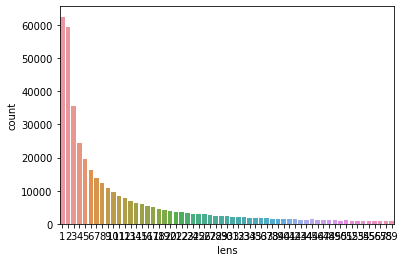

In [ ]:
sns.countplot(df_final.lens)

In [ ]:
#balance the negative and positive data
from sklearn.utils import resample

df_majority = df_final[df_final.recommend==1]
df_minority = df_final[df_final.recommend==-1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=296086,    # to match majority class
                                 random_state=235) # reproducible results
 
# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])
 

#replace outcome label -1 with 0
#df_balanced['recommend'] = df_balanced['recommend'].replace([-1],0)
# Display new class counts
df_balanced.recommend.value_counts()

1    296086
0    296086
Name: recommend, dtype: int64

In [ ]:
# Build model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced.cleaned,df_balanced.recommend,
test_size=0.2,stratify=df_balanced.recommend)


In [ ]:
#Bag of Words + XGBoost
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
#Start with Bag of Words
vectorizer = CountVectorizer(analyzer = "word", max_features=1500, min_df=.01, max_df=0.7) 
bow_train = vectorizer.fit_transform(X_train).toarray()

In [ ]:
#XGB classifier
BOW_XGB = xgb.XGBClassifier(max_depth=7, n_estimators=300, objective="binary:logistic", 
                            random_state=1, tree_method='gpu_hist', predictor='gpu_predictor')
BOW_XGB_scores = cross_val_score(BOW_XGB, bow_train, y_train, cv=3, n_jobs=-1)
print("Averaged CV Accuracy: %0.5f" % BOW_XGB_scores.mean())

BOW_XGB.fit(bow_train, y_train)


In [ ]:
bow_test = (vectorizer.transform(X_test)).toarray()
XGB_pred = BOW_XGB.predict(bow_test)

In [ ]:
BOW_XGB_scores_test = cross_val_score(BOW_XGB, bow_test, y_test, cv=3, n_jobs=-1)
print("Averaged CV Accuracy: %0.5f (+/- %0.5f)" % (BOW_XGB_scores_test.mean(), BOW_XGB_scores_test.std() * 2))

In [ ]:
# LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:

max_features = 200000  # Only consider the top 200k words
maxlen = 60
embedding_dim = 128


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
import string
import re
vectorization_layer = TextVectorization(max_tokens=max_features,
    output_mode='int',
    output_sequence_length=maxlen)

vectorization_layer.adapt(X_train.values)
vectorization_layer.adapt(X_test.values)

In [ ]:
#build CNN model
def CNN_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape=(None,), dtype=tf.string))
  model.add(vectorization_layer)
  model.add(layers.Embedding(max_features, embedding_dim))
  model.layers[1].trainable = False

  model.add(tf.keras.layers.Conv1D(
    filters=5, 
    kernel_size=3, 
    strides=1, 
    padding='same', 
    activation='relu', 
    use_bias=True,
    kernel_initializer='glorot_uniform', 
    bias_initializer='zeros')
            )    
  model.add(layers.GlobalAveragePooling1D())
  model.add(layers.Dense(64, activation="relu"))
  #model.add(layers.Dropout(0.05))
  model.add(layers.Dense(1, activation="sigmoid"))

  model.summary()

  model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics="accuracy")
  return model

In [ ]:
#train CNN
CNN_model=CNN_model()
history = CNN_model.fit(
   X_train,y_train,validation_data=(X_test, y_test),
   epochs=10,batch_size=128)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 60)                0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 128)           25600000  
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 5)             1925      
_________________________________________________________________
global_average_pooling1d (Gl (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                384       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 25,602,374
Trainable params: 2,374
Non-trainable params: 25,600,000
________________________________________

In [ ]:
#build LSTM

def LSTM_model():

  # A integer input for vocab indices.
  model = tf.keras.models.Sequential()
  
  model.add(tf.keras.Input(shape=(None,), dtype=tf.string))

  # Next, we add a layer to map those vocab indices into a space of dimensionality
  # 'embedding_dim'.
  model.add(vectorization_layer)
  model.add(tf.keras.layers.Embedding(max_features, embedding_dim))
  model.layers[1].trainable = False

  # Add bidirectional LSTM
  model.add(tf.keras.layers.LSTM(60, return_sequences=True,name='lstm'))
  model.add(tf.keras.layers.GlobalMaxPool1D())
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(50,activation="relu"))
  model.add(tf.keras.layers.Dropout(0.1))


  # Add a classifier
  model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

  model.summary()
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  return model

In [ ]:
#train LSTM
model_LSTM=LSTM_model()
model_LSTM.fit(np.array(X_train),y_train, validation_data=(X_test, y_test),epochs=20, batch_size=128)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 128)           25600000  
_________________________________________________________________
lstm (LSTM)                  (None, 60, 60)            45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)               

In [ ]:
#BERT model

In [ ]:
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

In [ ]:

import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from datetime import datetime



In [ ]:
from sklearn.model_selection import train_test_split

train,test= train_test_split(df_balanced,
test_size=0.2)


In [ ]:
#Build Bert Model with tf_hub
import tensorflow_hub as hub
import tensorflow_datasets as tfds

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"


In [ ]:
#convert pandas dataframe to tensorflow dataset
tf.enable_eager_execution()

In [ ]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(train["cleaned"].values, tf.string),
            tf.cast(train['recommend'].values, tf.int32)
        )
    )
)

In [ ]:
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(test["cleaned"].values, tf.string),
            tf.cast(test['recommend'].values, tf.int32)
        )
    )
)

In [ ]:
#build BERT 
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
def BERT_model():
  model = tf.keras.Sequential()
  model.add(hub_layer)
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(16, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.summary()
  model.compile(optimizer= tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model



In [ ]:
BERT_model=BERT_model()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_15 (Dense)             (None, 16)                816       
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = BERT_model.fit(train_dataset.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=test_dataset.batch(512),
                    verbose=1)

Epoch 1/20
926/926 [==============================] - 29s 32ms/step - loss: 0.1813 - accuracy: 0.9284 - val_loss: 0.2633 - val_accuracy: 0.9026
Epoch 2/20
926/926 [==============================] - 29s 32ms/step - loss: 0.1741 - accuracy: 0.9320 - val_loss: 0.2628 - val_accuracy: 0.9053
Epoch 3/20
926/926 [==============================] - 29s 32ms/step - loss: 0.1675 - accuracy: 0.9349 - val_loss: 0.2626 - val_accuracy: 0.9061
Epoch 4/20
926/926 [==============================] - 30s 32ms/step - loss: 0.1616 - accuracy: 0.9376 - val_loss: 0.2633 - val_accuracy: 0.9073
Epoch 5/20
926/926 [==============================] - 30s 32ms/step - loss: 0.1563 - accuracy: 0.9400 - val_loss: 0.2644 - val_accuracy: 0.9092
Epoch 6/20
926/926 [==============================] - 29s 32ms/step - loss: 0.1513 - accuracy: 0.9423 - val_loss: 0.2658 - val_accuracy: 0.9102
Epoch 7/20
926/926 [==============================] - 29s 32ms/step - loss: 0.1468 - accuracy: 0.9443 - val_loss: 0.2693 - val_accuracy: